# CAS Data Engineering FHNW - FS2024
## Data Wrangling Module - Author F.Burnelli

1. Profiling:
2. Completeness: (Missing Data,etc.)
3. Integrity
4. Consistency
5. Working with Text - Part 1
6. Enrichment

- run_pipeline()
  - extract_data(df)
  - missings_columns(df)
  - integrity_duplicates(df)
  - integrity_data_types(df)
  - consistency_business_rules(df)
  - working_with_text(df)
  - enrichment(df)  
  - data_protection(df)  
  - persist_data

### Dataset: LendingClub

Ein Kaggle-Datensatz, der auch in anderen CAS-Modulen verwendet werden wird.<br>
1. Dataset link: https://www.kaggle.com/datasets/husainsb/lendingclub-issued-loans
2. Schema infos: https://www.openintro.org/data/index.php?data=loans_full_schema
3. Context: Loan data for all loans issued through the time period stated in US area.
4. Content:Training set (data from 2007 till 2015) and test set (data from 2016 till 2017).
### NOTE HERE WE USE A SAMPLE: lc_loan_sample.csv

other options: copy the requirements.txt to /root/work/ and run

pip install -r requirements.txt

Using Conda:
```
conda create --name cas_de python=3.9
conda install --file requirements.txt
python -m ipykernel install --user --name=cas_de
```
Using pip:
```
pip install -r requirements.txt
```
in Deepnote : copy the requirements.txt to /root/work/ and run pip install -r requirements.txt

# 

In [258]:
import sys
import warnings

# Wrangling
import pandas as pd
import numpy as np

# Profiling
import missingno as msno
from ydata_profiling import ProfileReport


### Vis
import matplotlib.pyplot as plt
import seaborn as sns

### Text
# not exact match search
from thefuzz import fuzz,process
# regexp
import re

# anonymisation

import hmac
import hashlib

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
%matplotlib inline

## Extract Data

In [259]:
df = pd.read_csv("lc_loan_sample.csv",low_memory = False)
            

In [260]:
df.head(3)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1069453,1303701,11000.0,11000.0,11000.0,36 months,6.62,337.75,A,A2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1067874,1302235,6000.0,6000.0,6000.0,60 months,12.69,135.57,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1057633,1289398,8450.0,8450.0,8425.0,60 months,16.77,208.97,D,D2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [261]:
df.shape

(17747, 74)

# Exercise 1 Memory for csv - json - parquet
Compare file size for fo csv,json and parquet


In [17]:
mem = sys.getsizeof(df.to_csv(index=False)) / (1024 * 1024)
print(f"Mem usage in MB CSV:{mem:.1f}")
mem = sys.getsizeof(df.to_json(orient='split')) / (1024 * 1024)
print(f"Mem usage in MB JSON - split:{mem:.1f}")
mem = sys.getsizeof(df.to_json(orient='records')) / (1024 * 1024)
print(f"Mem usage in MB JSON - records:{mem:.1f}")
mem = sys.getsizeof(df.to_json(orient='values')) / (1024 * 1024)
print(f"Mem usage in MB JSON - values:{mem:.1f}")
mem = sys.getsizeof(df.to_json(orient='index')) / (1024 * 1024)
print(f"Mem usage in MB JSON - index:{mem:.1f}")
mem = sys.getsizeof(df.to_json(orient='columns')) / (1024 * 1024)
print(f"Mem usage in MB JSON - columns:{mem:.1f}")
mem = sys.getsizeof(df.to_parquet())/ (1024 * 1024)
print(f"Mem usage in MB PARQUET:{mem:.1f}")


Mem usage in MB CSV:16.8
Mem usage in MB JSON - split:10.7
Mem usage in MB JSON - records:29.2
Mem usage in MB JSON - values:10.6
Mem usage in MB JSON - index:29.3
Mem usage in MB JSON - columns:19.8
Mem usage in MB PARQUET:2.4


In [18]:
profile = ProfileReport(df, title='Loan Dataset Profiling Report', minimal=True)
profile.to_file(output_file='lc_loan_sample_profiling.html')

# Some Output examples https://github.com/ydataai/ydata-profiling#-examples

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Exercise 2 
... run profiling on your data

## Missing Data
Identify columns with missing
Analyze those columns

### Column level

In [262]:
def identify_cols_missing(df):
    """ Find Columns with Missing Values and Their Data Types
        Parameters:
        -----------
        df : pandas.DataFrame
        The input DataFrame to analyze for missing values. 
        Returns:
        --------
        list of tuples  (column_name, data type)  of columns having missing values.
    """
    cols_with_missing = [(column_name, df[column_name].dtype)
                        for column_name in df.columns[df.isna().any()]]
    return cols_with_missing
    


In [264]:
cols_with_missing = identify_cols_missing(df)
print(f'{len(cols_with_missing)} have missings')
for missing in cols_with_missing:
    print(missing)

39 have missings
('emp_title', dtype('O'))
('emp_length', dtype('O'))
('annual_inc', dtype('float64'))
('desc', dtype('O'))
('title', dtype('O'))
('delinq_2yrs', dtype('float64'))
('earliest_cr_line', dtype('O'))
('inq_last_6mths', dtype('float64'))
('mths_since_last_delinq', dtype('float64'))
('mths_since_last_record', dtype('float64'))
('open_acc', dtype('float64'))
('pub_rec', dtype('float64'))
('revol_util', dtype('float64'))
('total_acc', dtype('float64'))
('last_pymnt_d', dtype('O'))
('next_pymnt_d', dtype('O'))
('collections_12_mths_ex_med', dtype('float64'))
('mths_since_last_major_derog', dtype('float64'))
('annual_inc_joint', dtype('float64'))
('dti_joint', dtype('float64'))
('verification_status_joint', dtype('O'))
('acc_now_delinq', dtype('float64'))
('tot_coll_amt', dtype('float64'))
('tot_cur_bal', dtype('float64'))
('open_acc_6m', dtype('float64'))
('open_il_6m', dtype('float64'))
('open_il_12m', dtype('float64'))
('open_il_24m', dtype('float64'))
('mths_since_rcnt_il', 

### plot missing: (in Black available)

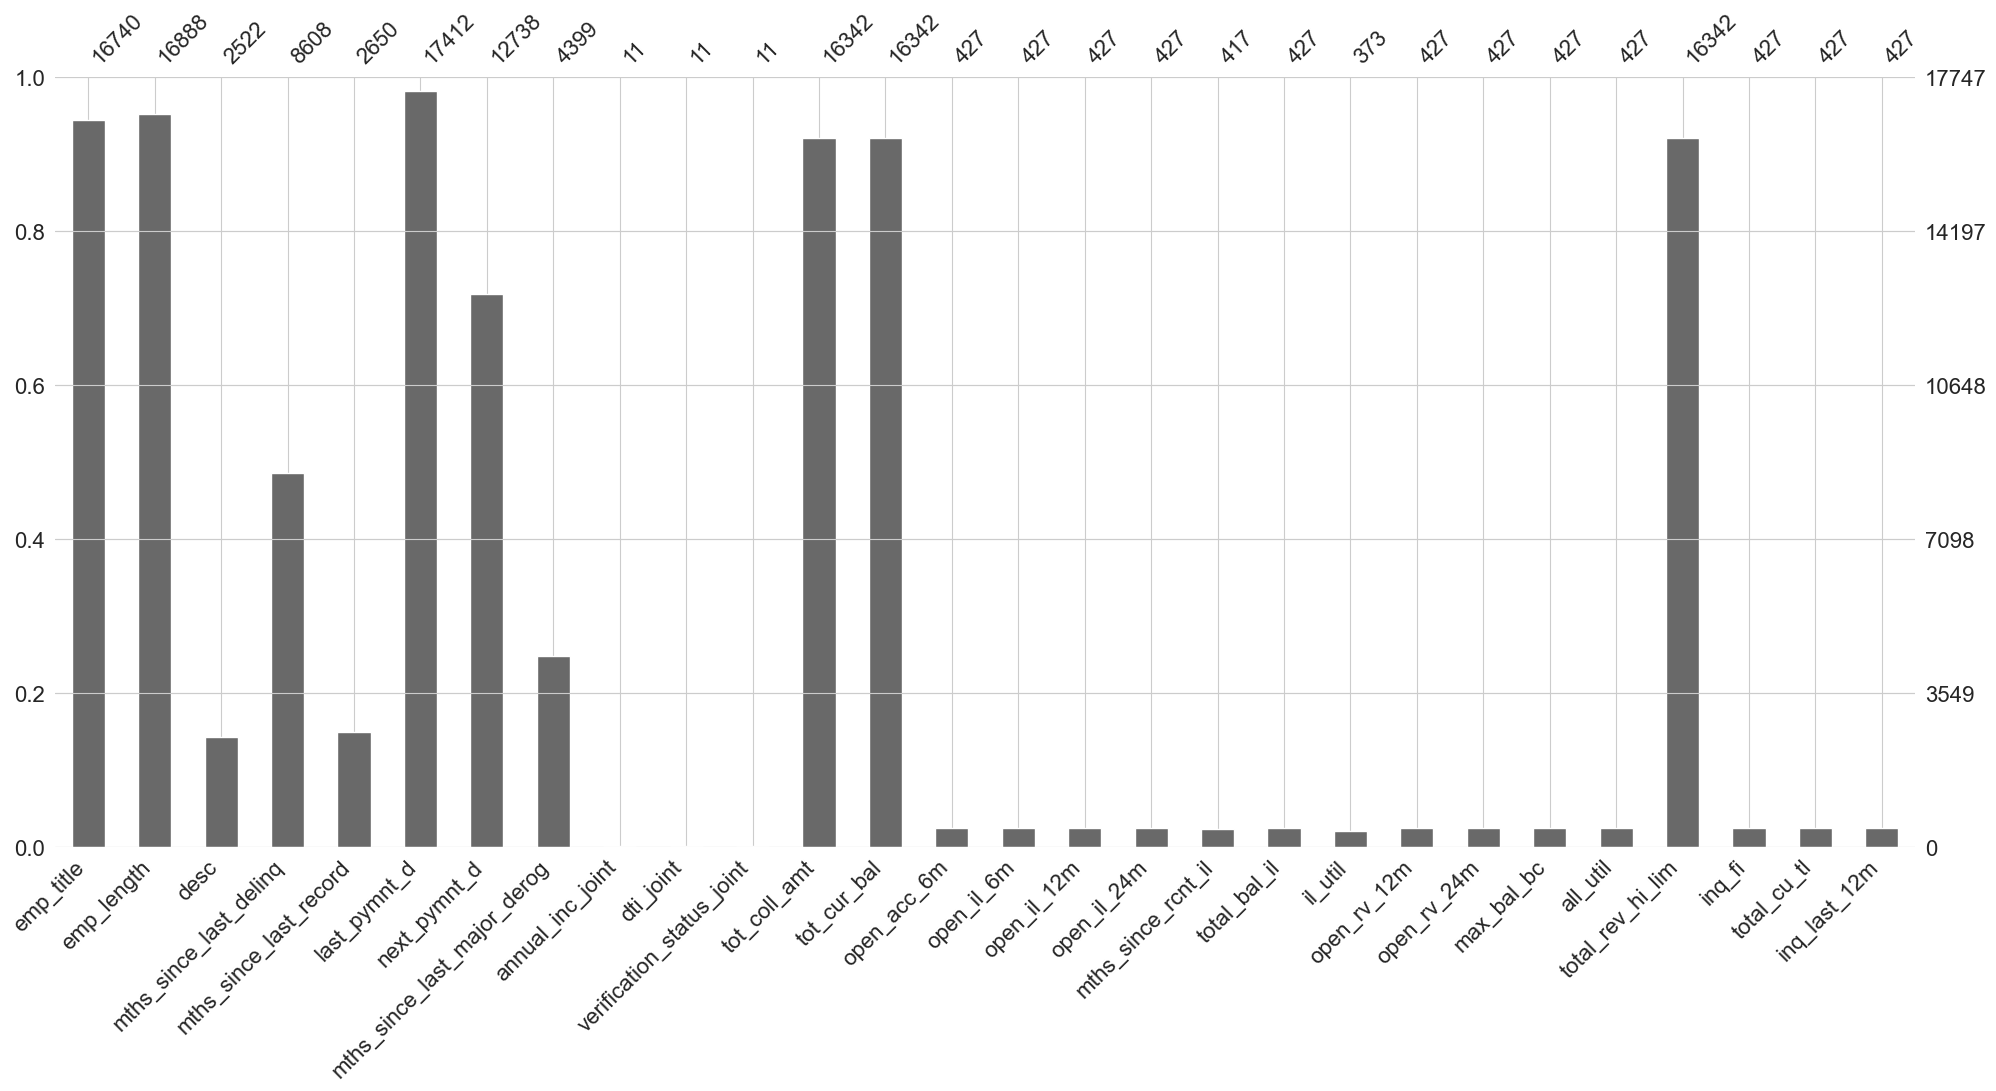

In [27]:
def plot_missing_data(df):
    """ plot Columns with Missing Values and Their Data Types
        Parameters:
        -----------
        df : pandas.DataFrame
        The input DataFrame to analyze for missing values. 
        Returns:
        --------
        None
    """
    threshold = int(df.shape[0]/100)# 1percent
    missing_counts = df.isnull().sum()
    df_missing = df[missing_counts[missing_counts > threshold].index.tolist()]
    msno.bar(df_missing)
    
plot_missing_data(df)


### Single value / Constant


In [266]:
def find_constants(df):
    """ Find Columns with a cinstant value
        Parameters:
        -----------
        df : pandas.DataFrame
        The input DataFrame to analyze for missing values. 
        Returns:
        --------
        List of Columns name
    """
    return df.columns[df.nunique() == 1].tolist()


In [267]:
find_constants(df)

['pymnt_plan', 'policy_code']

In [265]:
def find_missing_cols(df,threshold=100):
    """ Find Columns with all (or threshold) missing 
        Parameters:
        -----------
        df : pandas.DataFrame
        The input DataFrame to analyze for missing values. 
        Returns:
        --------
        List of Columns name
    """
    return [col for col in df.columns if df[col].count() < threshold]



In [268]:
find_missing_cols(df,threshold=100)

['annual_inc_joint', 'dti_joint', 'verification_status_joint']

### Record Level

## Exercise 3 : Heatmap Missingness correlation

####  Heatmap Missingness correlation

<AxesSubplot: >

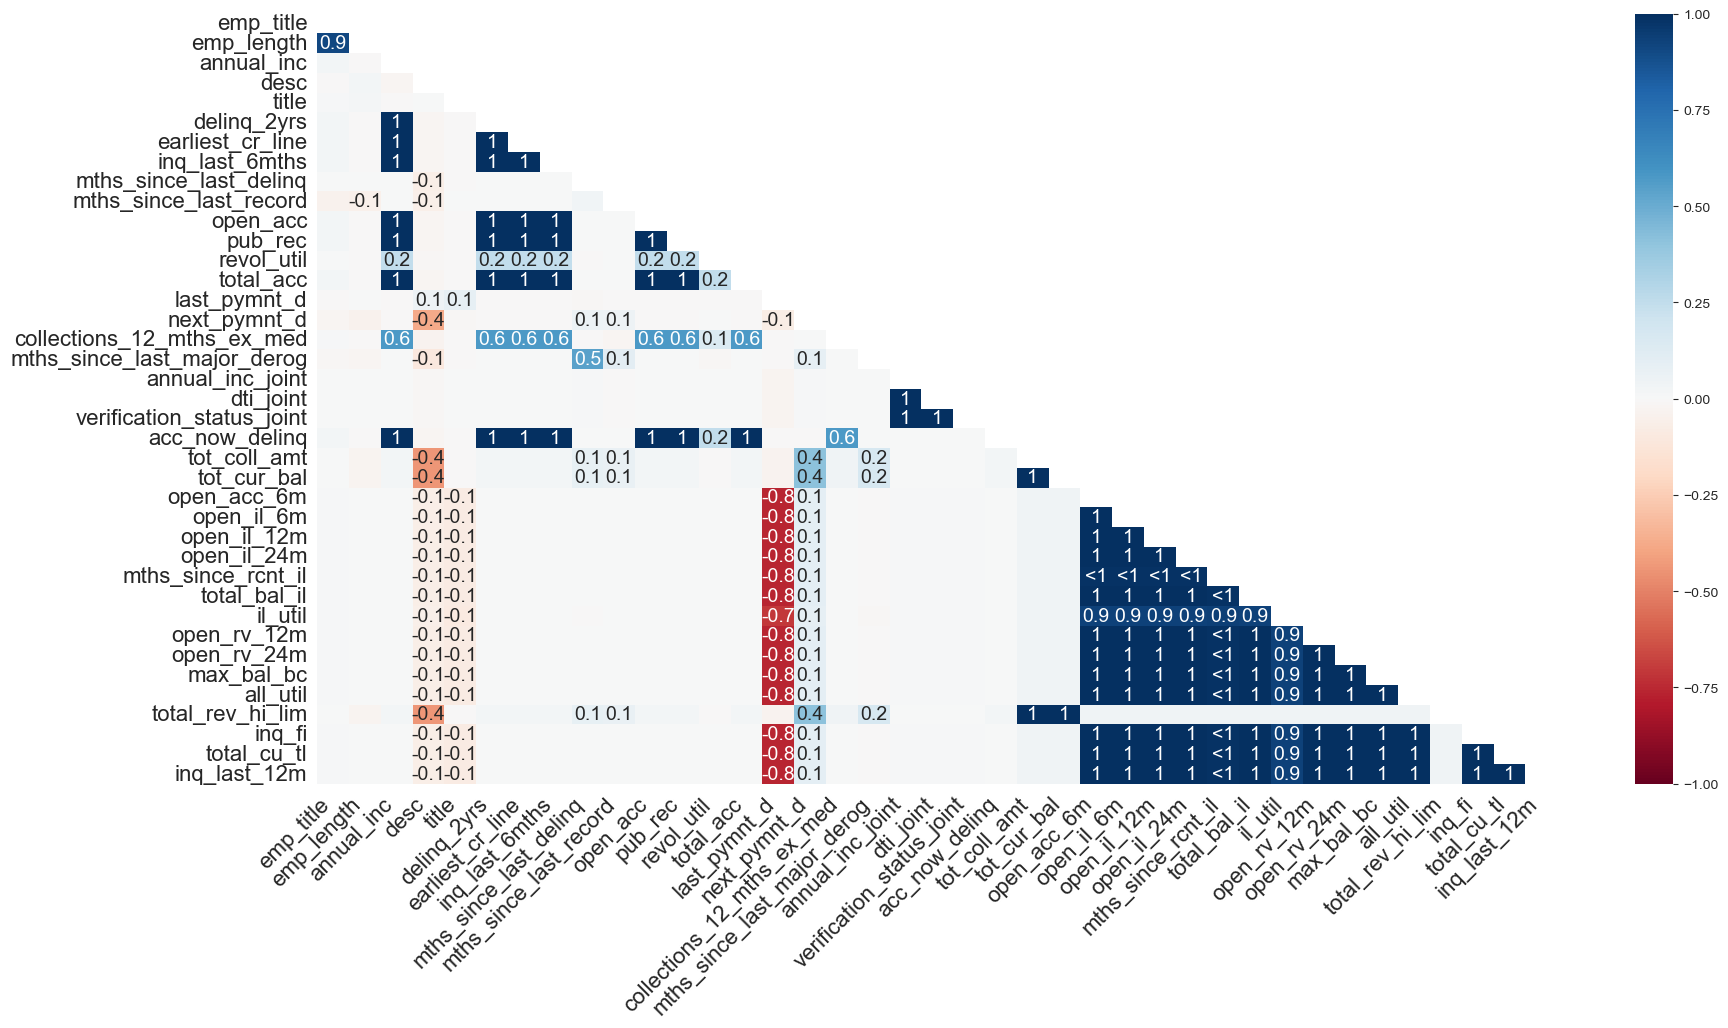

In [80]:
msno.heatmap(df,figsize=(20,10))#, inline=True, sparkline=True, figsize=(20,10), sort=None, color=(0.25, 0.45, 0.6))

<AxesSubplot: >

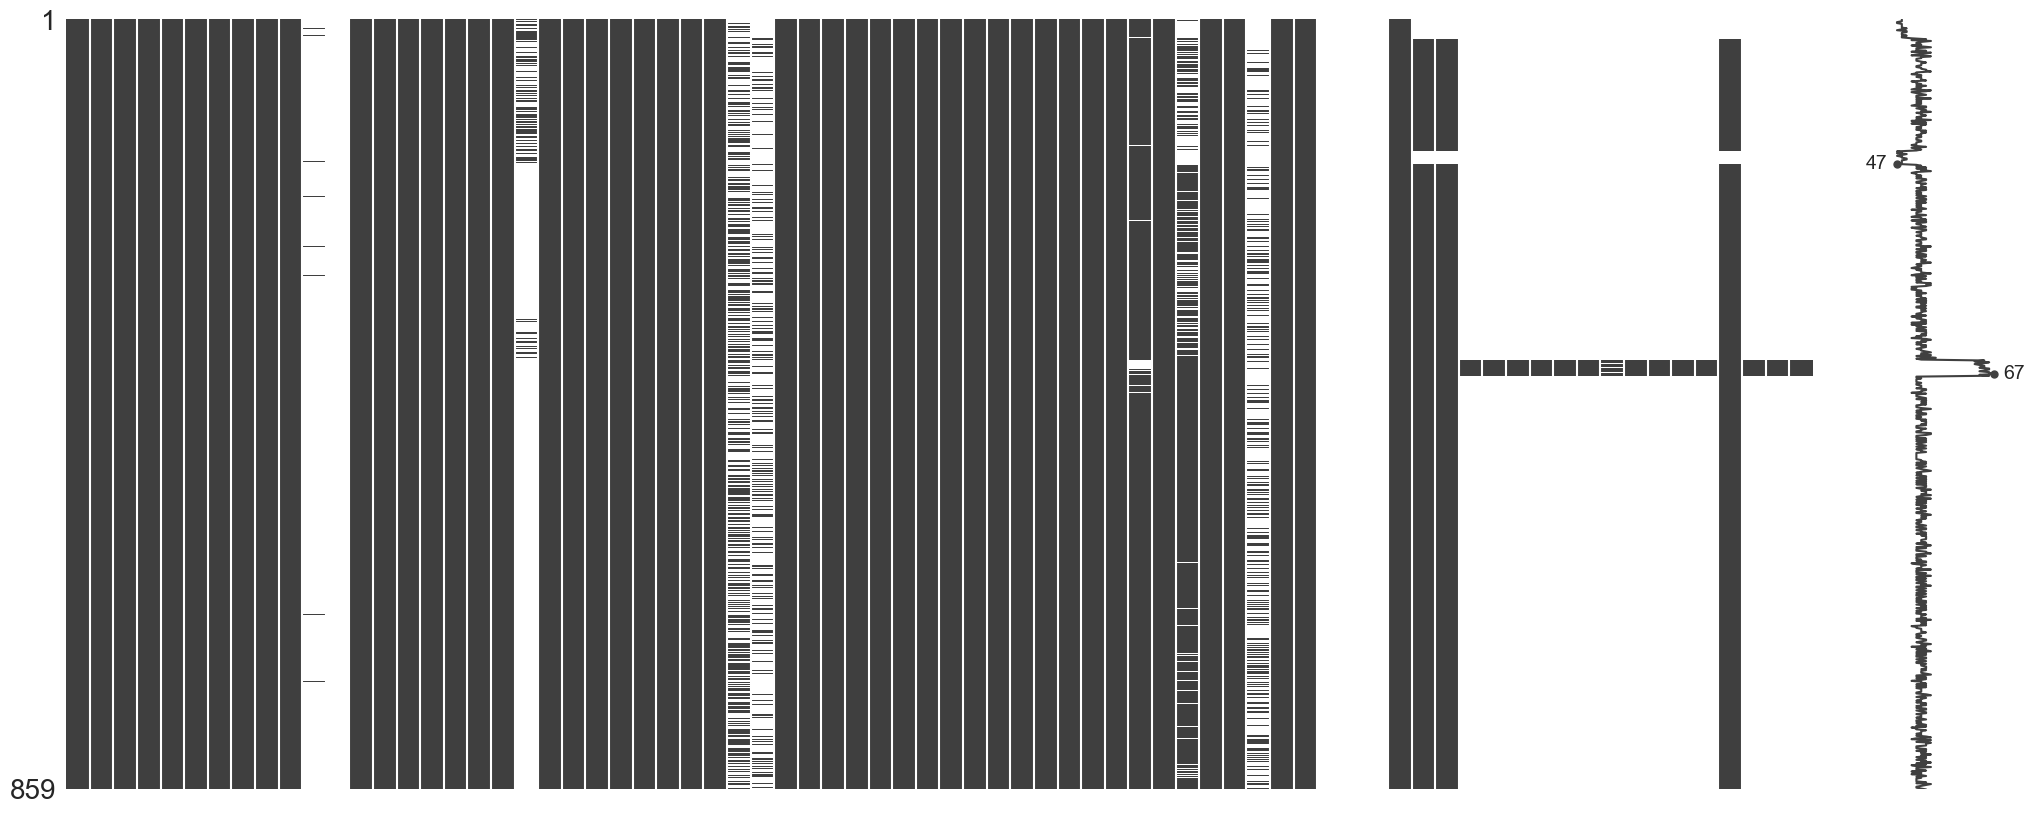

In [77]:
# white missing; on the right sparkline
msno.matrix(df[df['emp_length'].isnull()])

<AxesSubplot: >

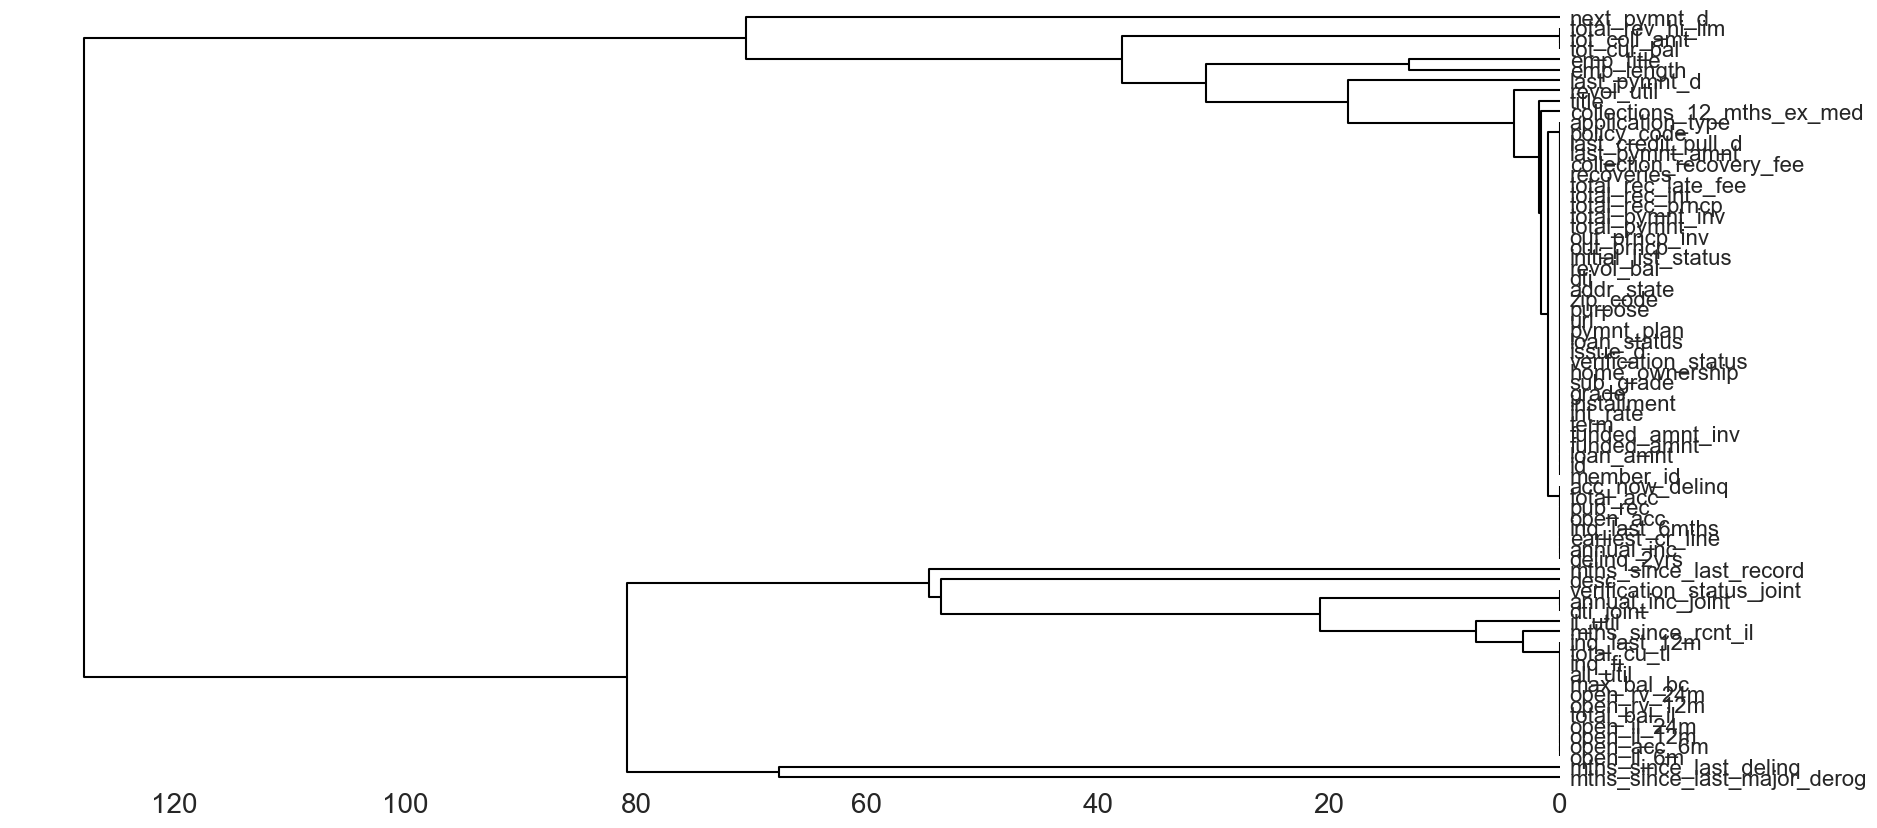

In [82]:
msno.dendrogram(df,figsize=(20,10))#, inline=True, sparkline=True, figsize=(20,10), sort=None, color=(0.25, 0.45, 0.6))

### Why Missing...?
Unemployment?
Technical Issue?

<AxesSubplot: >

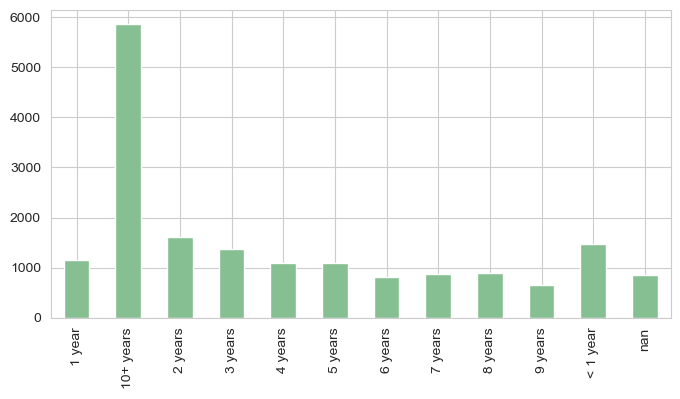

In [7]:
df['emp_length'].value_counts(dropna=False).sort_index().plot(kind='bar', color='#86bf91', figsize=(8, 4))


### trying to understand which employment title....

In [73]:
filtered_rows = df[df['emp_length'].isnull()][['emp_title', 'emp_length']]
filtered_rows.groupby('emp_title', dropna=False).size().reset_index(name='count')

,emp_title,count
0,AL Medicaid Agency,1
1,Aegis Communications Group,1
2,Consultant,1
3,Intern,1
4,JP Morgan Chase,1
5,Retired,1
6,SALES ASSOCIATE,1
7,The Rockefeller University,1
8,customer service,1
9,first student management,1


In [60]:
emp = df[df['emp_length'].isnull()][['emp_title', 'emp_length']]


,emp_title,emp_length
22,NaN,NaN
267,Aegis Communications Group,NaN
512,AL Medicaid Agency,NaN
2880,JP Morgan Chase,NaN
3578,Retired,NaN
4557,first student management,NaN
4573,The Rockefeller University,NaN
5522,Consultant,NaN
6673,SALES ASSOCIATE,NaN
7553,customer service,NaN


### Row Level
Check Missings at Row Level
Reconciliate this volume with primary source

In [28]:
df.shape

(17747, 74)

### Business Plausibilisierung
Looking by year... is as expected?

In [14]:
pd.to_datetime(df['issue_d'], format='%b-%Y').dt.year.value_counts().sort_index()



2007      12
2008      47
2009     107
2010     250
2011     434
2012    1066
2013    2697
2014    4712
2015    8422
Name: issue_d, dtype: int64

<AxesSubplot: >

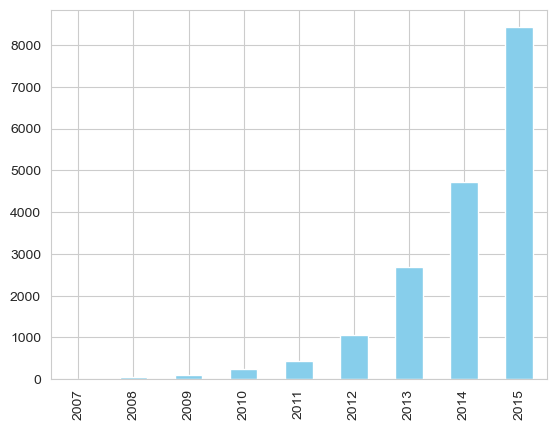

In [270]:
pd.to_datetime(df['issue_d'], format='%b-%Y').dt.year.value_counts().sort_index().plot(kind='bar', color='skyblue')


### Numpy NaN
isna isnull isnan are same

In [52]:
print(None==None)
print(np.nan==np.nan)
print(np.nan+1)

True
False
nan


## Integrity

### Duplicates

In [271]:
print(f"""duplicates in dataframe :{df.duplicated().sum()}""")    

duplicates in dataframe :0


### Data types: change data type where appropriate

In [272]:
df.issue_d.head(3)

0    Dec-2011
1    Dec-2011
2    Dec-2011
Name: issue_d, dtype: object

In [273]:
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%Y')


In [274]:
df.issue_d.head(3)

0   2011-12-01
1   2011-12-01
2   2011-12-01
Name: issue_d, dtype: datetime64[ns]

In [275]:
df.emp_length

0          5 years
1         < 1 year
2          5 years
3          6 years
4          3 years
           ...    
17742    10+ years
17743      7 years
17744     < 1 year
17745       1 year
17746      2 years
Name: emp_length, Length: 17747, dtype: object

## Consistency

### Inconsistent categories

In [92]:
df.purpose.head(5)

0    debt_consolidation
1        major_purchase
2    debt_consolidation
3    debt_consolidation
4        small_business
Name: purpose, dtype: object

In [ ]:
###  

In [93]:
unique_purposes = df['purpose'].unique().tolist()
unique_purposes

['debt_consolidation',
 'major_purchase',
 'small_business',
 'credit_card',
 'house',
 'home_improvement',
 'other',
 'vacation',
 'medical',
 'wedding',
 'car',
 'renewable_energy',
 'moving',
 'educational']

In [94]:
reference_categories = unique_purposes

### For sake of exercise 
Suppose "car" is not a valid category

In [96]:
df.groupby('purpose').size().reset_index(name='count')

,purpose,count
0,car,193
1,credit_card,4184
2,debt_consolidation,10391
3,educational,7
4,home_improvement,1078
5,house,61
6,major_purchase,381
7,medical,163
8,moving,98
9,other,858


In [103]:
values_to_remove = ["car","major_purchase"]

reference_categories = [x for x in reference_categories if x not in values_to_remove]
reference_categories

['debt_consolidation',
 'small_business',
 'credit_card',
 'house',
 'home_improvement',
 'other',
 'vacation',
 'medical',
 'wedding',
 'renewable_energy',
 'moving',
 'educational']

In [101]:
def find_inconsistent_categories(df,col,reference_categories):
    """ Find Inconsisten categories 
        Parameters:
        -----------
        df : pandas.DataFrame
        The input DataFrame to analyze 
        Returns:
        --------
        List of Columns name
    """
    unique_values = df[col].unique()
    return [value for value in unique_values if value not in reference_categories]




['car']

In [104]:
inconsistent_categories = find_inconsistent_categories(df,'purpose',reference_categories)


In [106]:
filtered_df = df[df['purpose'].isin(inconsistent_categories)]
filtered_df.groupby('purpose').size().reset_index(name='count')

,purpose,count
0,car,193
1,major_purchase,381


### Cross fields Rules
Example: Sub Grade must match the Grade
ex : SUBGRADE A1 --> GRADE must be A

In [133]:
custom_check = lambda row : row['grade'] == row['sub_grade'][0]
df.apply(custom_check, axis=1)
mask = df.apply(custom_check, axis=1)


In [134]:
df[~mask]

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m


## Working with Text: Part 1

### Regexp

In [136]:
url_pattern = r'^https?://(www\.)?[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}(/\S*)?$'
assert all(df['url'].str.match(url_pattern)), "Not all URLs are valid"


### Exercise : why it Fails?

In [138]:
regex_check = lambda row: bool(re.match(r'^[a-fA-F]', row['sub_grade']))
assert df.apply(regex_check, axis=1).all(), "AssertionError: Regex check failed."


AssertionError: AssertionError: Regex check failed.

### Emp Title

### High Cardinality

In [139]:
df['emp_title'].nunique()

10654

### Harmonise:Lowercase, Strip

In [142]:
df['emp_title'].str.lower().nunique()

9720

In [143]:
df['emp_title'].str.lower().str.strip().nunique()


9450

In [144]:
df['emp_title'] = df['emp_title'].str.lower().str.strip()


9450

### Exploration

In [ ]:
Alphabetic sort

In [306]:
#todo mixed types
sorted(df['emp_title'].astype(str).unique())[0:10]

['1. lpn/ 2. driver',
 '10',
 '1st assistant manager',
 '1st sergeant',
 '21st century security',
 '24 hour fitness',
 '245 e realty corp',
 '26726 crown vahead  and  neck associates',
 '2nd class petty officer',
 '2nd class warehouseman']

In [ ]:
Top 20

In [172]:
def top20(df):
    print(df['emp_title'].str.lower().groupby(df['emp_title']\
          .str.lower()).size().reset_index(name='count')\
          .sort_values(by='count', ascending=False).head(20)
         )

    

In [173]:
top20(df)

               emp_title  count
8470             teacher    341
6817    registered nurse    312
4990             manager    297
5864               owner    152
8285          supervisor    131
2737              driver    126
5710      office manager    113
7086               sales    107
3563     general manager     94
6508     project manager     89
8818        truck driver     82
2943            engineer     69
2498            director     69
6236      police officer     61
8545          technician     60
6313           president     60
7123       sales manager     59
5779  operations manager     52
96            accountant     49
1015      branch manager     48


In [175]:
df['emp_title'].str.lower().str.strip().nunique()

9450

###... noticed rn ..is registered nurse???

In [152]:
df['emp_title'].replace('rn', 'registered nurse	', inplace=True)
df['emp_title'].replace('registered nurse	', 'registered nurse', inplace=True)
top20(df)

               emp_title  count
8470             teacher    341
6817    registered nurse    312
4990             manager    297
5864               owner    152
8285          supervisor    131
2737              driver    126
5710      office manager    113
7086               sales    107
3563     general manager     94
6508     project manager     89
8818        truck driver     82
2943            engineer     69
2498            director     69
6236      police officer     61
8545          technician     60
6313           president     60
7123       sales manager     59
5779  operations manager     52
96            accountant     49
1015      branch manager     48


## Deduplicate
### Already harmonised
### Clustering: Business Rule from Top 20
### Match
### Identify Threshold
### Merge



In [176]:
# Define the Cluster
cluster_string = 'teacher'
col = 'emp_title'


In [177]:
# Match
def matching(cluster_string,col):
    #the fuzzy match
    return process.extract(cluster_string, df[col].unique(), limit = len(df[col].unique()))



In [178]:
matching(cluster_string,col)

[('teacher', 100),
 ('teachers', 93),
 ('biology teacher', 90),
 ('bilingual teacher', 90),
 ('toddler teacher', 90),
 ('substitute teacher', 90),
 ('mathematics teacher', 90),
 ('english teacher', 90),
 ("teacher's aide", 90),
 ('reading teacher', 90),
 ('infant teacher', 90),
 ('teacher/coach', 90),
 ('teacher assistant', 90),
 ('special education teacher', 90),
 ('teacher / coach', 90),
 ('lead special ed teacher', 90),
 ('master teacher', 90),
 ('teacher aid', 90),
 ('science lab teacher', 90),
 ('athletic administrator/teacher', 90),
 ('lead teacher', 90),
 ('elementary pe teacher', 90),
 ('science teacher', 90),
 ('retired teacher now substituting', 90),
 ('coach teacher', 90),
 ('math teacher', 90),
 ('coordinator/teacher', 90),
 ('athletic trainer/teacher', 90),
 ('teacher/athletic director', 90),
 ('art teacher', 90),
 ('teacher assistant/bus driver', 90),
 ('music teacher', 90),
 ('pre school teacher', 90),
 ('teacher - coach', 90),
 ('athletic director/teacher', 90),
 ('kind

In [179]:
### Let's Take 90 as a Threshold

In [180]:
threshold = 90

In [190]:
def harmonise_with_threshold(col,cluster_string,threshold):
    for val, similarity in process.extract(cluster_string, df[col].unique(), limit = len(df[col].unique())):
        if similarity >= threshold:
            df[col][df[col] == val] = cluster_string



In [191]:
harmonise_with_threshold('emp_title','teacher',90)

top20(df)    

               emp_title  count
8440             teacher    402
6792    registered nurse    312
4972             manager    297
5842               owner    152
8255          supervisor    131
2727              driver    126
5688      office manager    113
7060               sales    107
3551     general manager     94
6485     project manager     89
8776        truck driver     82
2932            engineer     69
2488            director     69
6214      police officer     61
8504          technician     60
6290           president     60
7097       sales manager     59
5757  operations manager     52
95            accountant     49
1007      branch manager     48


In [192]:
df['emp_title'].str.lower().str.strip().nunique()

9407

In [194]:
df['emp_title'].str.lower().str.strip().unique()

array(['cognizant technology solutions', 'anadarko petroleum corporation',
       'best buy', ..., 'job opportunityspecialist',
       'junior system administrator', 'mission info tech'], dtype=object)

In [196]:
#df['emp_title'].str.lower().fillna('null').groupby(df['emp_title'].str.lower().fillna('null')).size().reset_index(name='count').to_csv('output.csv', index=False)

In [198]:
df['emp_title'].replace('sr.', 'senior', inplace=True)
df['emp_title'].replace('tech ', 'technology', inplace=True)
df['emp_title'].replace('"', '', inplace=True)
df['emp_title'].nunique()


9407

## Enrichment
#### As exercise to combine datasets... 
#### https://data.world/peopledatalabs/similar-job-titles-74567-unique-job-titles
#### Description of data:Using our 1.2 billion person profiles, we built a relational dataset of job titles that appear frequently together.


### Load the data from 2019_free_title_data.csv"

In [211]:
df_titles = pd.read_csv("2019_free_title_data.csv",low_memory = False)


#### What is in the Data?

In [230]:
df_titles.title.nunique(5)

4988

In [217]:
df_titles.shape

(5000, 21)

In [232]:
df_titles.head(3)

,title,pdl count,top related titles 1,top related titles 2,top related titles 3,top related titles 4,top related titles 5,top related titles 6,top related titles 7,top related titles 8,...,top related titles 10,top related titles 11,top related titles 12,top related titles 13,top related titles 14,top related titles 15,top related titles 16,top related titles 17,top related titles 18,top related titles 19
0,owner,16780096,marketing strategy,strategic planning,entrepreneurship,marketing,team building,small business,customer service,social media,...,president,partner,manager,ceo,director,founder,business owner,co-owner,co owner,general manager
1,manager,11082930,customer service,leadership,inventory management,sales,team management,customer satisfaction,training,business strategy,...,general manager,assistant manager,senior manager,branch manager,director,owner,supervisor,business manager,consultant,sales manager
2,president,7169098,leadership,contract negotiation,team building,business development,new business development,public speaking,budgets,nonprofits,...,owner,board member,vice president,senior management,member,ceo,founder,chairman,chief executive officer,principal


In [236]:
df_titles_sorted = df_titles.sort_values(by='pdl count', ascending=False)
df_titles_sorted[['pdl count', 'title']]

,pdl count,title
0,16780096,owner
1,11082930,manager
2,7169098,president
3,5125942,director
4,4172319,ceo
...,...,...
4995,13137,callcenter agent
4996,13137,professional athlete
4997,13136,corporate account executive
4998,13132,trade marketing


In [ ]:
#### ... could be used to deduplicate emp_title....

In [228]:
df.shape

(17747, 74)

#### Combine (in pandas is merge) 

In [240]:
merged=df.merge(df_titles, left_on='emp_title', right_on='title', )

In [241]:
merged.shape

(9047, 95)

#### How does the columns look like

In [249]:
merged.filter(like='title')

,emp_title,title_x,title_y,top related titles 1,top related titles 2,top related titles 3,top related titles 4,top related titles 5,top related titles 6,top related titles 7,...,top related titles 10,top related titles 11,top related titles 12,top related titles 13,top related titles 14,top related titles 15,top related titles 16,top related titles 17,top related titles 18,top related titles 19
0,NaN,LC Loan,NaN,planejamento empresarial,dos,sistemas operacionais,erp planejamento de recursos empresariais,banco de investimento,mercado de capitais,investimentos,...,diretor,empreendedor / autônomo,sócio/proprietário,outros,dentista,gestor de área,despachante aduaneiro,analista,engenheiro,sócio
1,NaN,Pay off bills,NaN,planejamento empresarial,dos,sistemas operacionais,erp planejamento de recursos empresariais,banco de investimento,mercado de capitais,investimentos,...,diretor,empreendedor / autônomo,sócio/proprietário,outros,dentista,gestor de área,despachante aduaneiro,analista,engenheiro,sócio
2,NaN,home loan,NaN,planejamento empresarial,dos,sistemas operacionais,erp planejamento de recursos empresariais,banco de investimento,mercado de capitais,investimentos,...,diretor,empreendedor / autônomo,sócio/proprietário,outros,dentista,gestor de área,despachante aduaneiro,analista,engenheiro,sócio
3,NaN,New Garage,NaN,planejamento empresarial,dos,sistemas operacionais,erp planejamento de recursos empresariais,banco de investimento,mercado de capitais,investimentos,...,diretor,empreendedor / autônomo,sócio/proprietário,outros,dentista,gestor de área,despachante aduaneiro,analista,engenheiro,sócio
4,NaN,Debt Consolidation,NaN,planejamento empresarial,dos,sistemas operacionais,erp planejamento de recursos empresariais,banco de investimento,mercado de capitais,investimentos,...,diretor,empreendedor / autônomo,sócio/proprietário,outros,dentista,gestor de área,despachante aduaneiro,analista,engenheiro,sócio
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9042,subject matter expert,Debt consolidation,subject matter expert,business process outsourcing bpo,transition management,amdocs,team management,service delivery,technical support,subject matter experts,...,senior subject matter expert,sr subject matter expert,subject matter expert (sme),process associate,team lead,quality analyst,technical support executive,team leader,team manager,process developer
9043,it architect,Debt consolidation,it architect,togaf,application architecture,solution architecture,it architecture,aix,soa,integration architecture,...,information technology architect,senior it architect,enterprise architect,it infrastructure architect,enterprise it architect,ict architect,it-architect,it solutions architect,infrastructure architect,executive it architect
9044,financial planner,Debt consolidation,financial planner,income protection,financial planning,superannuation,retirement planning,wealth management,strategic financial planning,investment strategies,...,financial advisor,senior financial planner,paraplanner,certified financial planner,financial adviser,associate financial planner,financial planning manager,advanced financial planner,wealth planner,private client adviser
9045,videographer,Debt consolidation,videographer,video editing,final cut pro,videographer,video production,camera operating,cinematography,camera operation,...,freelance videographer,videographer/editor,video editor,video producer,camera operator,cinematographer,videographer and editor,video production specialist,director of photography,production assistant


#### What about NaN?

In [250]:
print(merged.groupby('emp_title', dropna=False).size().reset_index(name='count').sort_values(by='count', ascending=False).head(30))
#how=

                     emp_title  count
1481                       NaN   1007
1384                   teacher    402
1095          registered nurse    312
775                    manager    297
890                      owner    152
1352                supervisor    131
443                     driver    126
870             office manager    113
1138                     sales    107
582            general manager     94
1027           project manager     89
1439              truck driver     82
410                   director     69
461                   engineer     69
945             police officer     61
1409                technician     60
957                  president     60
1154             sales manager     59
879         operations manager     52
11                  accountant     49
157             branch manager     48
1449            vice president     47
1250                    server     46
42    administrative assistant     46
811                   mechanic     46
7           

In [253]:
merged=df.merge(df_titles.dropna(subset=['title']), left_on='emp_title', right_on='title', )
print(merged.groupby('emp_title', dropna=False).size().reset_index(name='count').sort_values(by='count', ascending=False).head(5))


             emp_title  count
1384           teacher    402
1095  registered nurse    312
775            manager    297
890              owner    152
1352        supervisor    131


In [254]:
merged.filter(like='title')

,emp_title,title_x,title_y,top related titles 1,top related titles 2,top related titles 3,top related titles 4,top related titles 5,top related titles 6,top related titles 7,...,top related titles 10,top related titles 11,top related titles 12,top related titles 13,top related titles 14,top related titles 15,top related titles 16,top related titles 17,top related titles 18,top related titles 19
0,us army,Debt,us army,military operations,military,military experience,force protection,security clearance,operational planning,weapons,...,u s army,military,national guard,jrotc instructor,us army retired,army national guard,platoon sergeant,military professional,army,us marine corps
1,us army,Business Starter,us army,military operations,military,military experience,force protection,security clearance,operational planning,weapons,...,u s army,military,national guard,jrotc instructor,us army retired,army national guard,platoon sergeant,military professional,army,us marine corps
2,us army,Clean up,us army,military operations,military,military experience,force protection,security clearance,operational planning,weapons,...,u s army,military,national guard,jrotc instructor,us army retired,army national guard,platoon sergeant,military professional,army,us marine corps
3,us army,Debt Consolidation,us army,military operations,military,military experience,force protection,security clearance,operational planning,weapons,...,u s army,military,national guard,jrotc instructor,us army retired,army national guard,platoon sergeant,military professional,army,us marine corps
4,us army,Home improvement,us army,military operations,military,military experience,force protection,security clearance,operational planning,weapons,...,u s army,military,national guard,jrotc instructor,us army retired,army national guard,platoon sergeant,military professional,army,us marine corps
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8035,subject matter expert,Debt consolidation,subject matter expert,business process outsourcing bpo,transition management,amdocs,team management,service delivery,technical support,subject matter experts,...,senior subject matter expert,sr subject matter expert,subject matter expert (sme),process associate,team lead,quality analyst,technical support executive,team leader,team manager,process developer
8036,it architect,Debt consolidation,it architect,togaf,application architecture,solution architecture,it architecture,aix,soa,integration architecture,...,information technology architect,senior it architect,enterprise architect,it infrastructure architect,enterprise it architect,ict architect,it-architect,it solutions architect,infrastructure architect,executive it architect
8037,financial planner,Debt consolidation,financial planner,income protection,financial planning,superannuation,retirement planning,wealth management,strategic financial planning,investment strategies,...,financial advisor,senior financial planner,paraplanner,certified financial planner,financial adviser,associate financial planner,financial planning manager,advanced financial planner,wealth planner,private client adviser
8038,videographer,Debt consolidation,videographer,video editing,final cut pro,videographer,video production,camera operating,cinematography,camera operation,...,freelance videographer,videographer/editor,video editor,video producer,camera operator,cinematographer,videographer and editor,video production specialist,director of photography,production assistant


## Exercise 4 : Handling Integrity

## Data Protection

###  Anonimisation

In [203]:
df['emp_title'].describe()

count       16740
unique       9407
top       teacher
freq          402
Name: emp_title, dtype: object

In [207]:
df['emp_title'].str.replace(r'(?<=^.{4}).*', '*', regex=True)


0        cogn*
1        anad*
2        best*
3          NaN
4        card*
         ...  
17742    envi*
17743    casi*
17744    job *
17745    juni*
17746    miss*
Name: emp_title, Length: 17747, dtype: object

In [208]:
df['member_id'].head(3)

0    1303701
1    1302235
2    1289398
Name: member_id, dtype: int64

In [209]:


def anonymize(member_id, private_key):
    member_id_bytes = str(member_id).encode('utf-8')
    private_key_bytes = str(private_key).encode('utf-8')
    hash_object = hmac.new(private_key_bytes, member_id_bytes, hashlib.sha256)
    hashed_member_id = hash_object.hexdigest()
    return hashed_member_id



Original Member ID: 1303701
Anonymized Member ID: b45a2b2f45aecb5fb58b547fe846977fcc56a256a231abc7cfad2425c89a0e30


In [ ]:
original_member_id = 1303701
private_key = "20241002"
anonymized_member_id = anonymize_member_id(original_member_id, private_key)

print(f"Original Member ID: {original_member_id}")
print(f"Anonymized Member ID: {anonymized_member_id}")

In [210]:
df['member_id'].apply(anonymize_member_id, private_key=private_key)


0        b45a2b2f45aecb5fb58b547fe846977fcc56a256a231ab...
1        e5f962363416ef1b0d8250d28c3a2214917b4446807a63...
2        42acedcb920dd3e5c0c69e1b012ebdd0858b7f06c40efe...
3        cd8168e1c6bbd7e70ef171e0ff051a63762b1545cb8373...
4        839a0a15ac0ce10c4c5477dafca25b15c30e01560a0e2f...
                               ...                        
17742    1a6f3da6e2a1a7027f3f398a778bec5381dff2cd4dfce7...
17743    83704466356635d659de5f47eeb3e4b773190a9e0ea51f...
17744    ce3a5a8f57ef2d21794de29126d7e2dab4ea63391d6c3b...
17745    e3dbca644fb89c498e8a5e9fdd4a6dc75fba8555f765e3...
17746    fe91c4093d8c2feff2bc3174dfb1377404f3ac3e1bc827...
Name: member_id, Length: 17747, dtype: object

Text(0, 0.5, 'Loan Status')

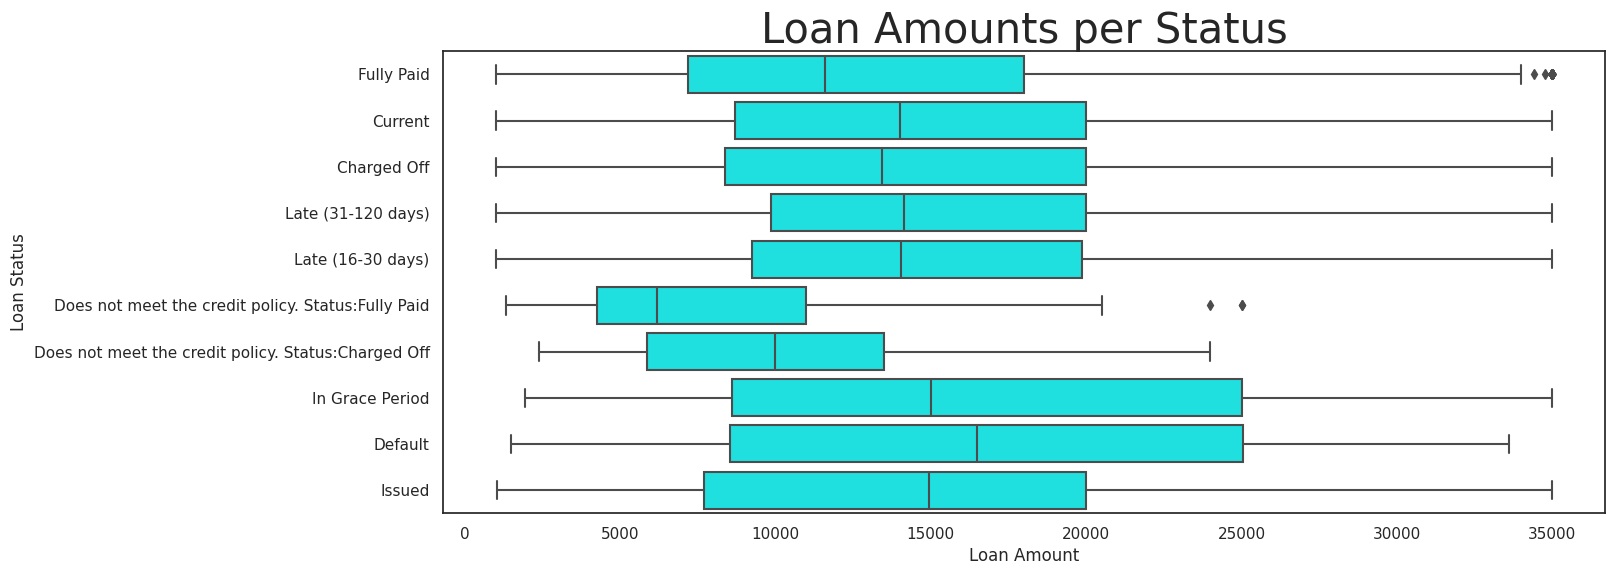

In [ ]:
ax = sns.boxplot(x='loan_amnt', y='loan_status', data=df,color="cyan")   
ax.set_title('Loan Amounts per Status',size=30)
ax.set_xlabel('Loan Amount')
ax.set_ylabel('Loan Status')

## Transforming and Persisting the data

## Persist

In [305]:
df.to_parquet('lc_loan_sample.parquet.gzip',compression='gzip')